In [1]:
#Load the usual suspects

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
# Load the data

with np.load('C:/Users/David Framil/Desktop/Simulations/cifar4-train.npz', allow_pickle=False) as npz_file:
    pixels = npz_file['pixels'].astype('float32')
    overfeat = npz_file['overfeat']
    labels = npz_file['labels']
    names = npz_file['names']
    allow = npz_file['allow_pickle']
    
print('Pixels : {:}'.format(pixels.shape),
      'Overfeat: {:}'.format(overfeat.shape),
      'Labels: {:}'.format(labels.shape),
      'Names: {:}'.format(names.shape), 
      'Allow pickle: {:}'.format(allow.shape))

Pixels : (5000, 3072) Overfeat: (5000, 4096) Labels: (5000,) Names: (4,) Allow pickle: ()


In [3]:
# Rename the data and split into train (4000) and test (1000) sets
X_ov = overfeat
X_px = pixels
y = labels

X_ov_tr, X_ov_te, X_px_tr, X_px_te, y_tr, y_te = train_test_split(X_ov, X_px, y, test_size=1000, stratify=y, random_state=0)

# Double check dimensions for the overfeat data:
print('Train set: {:}'.format(X_ov_tr.shape), 'Test set: {:}'.format(X_ov_te.shape))

Train set: (4000, 4096) Test set: (1000, 4096)


In [4]:
# Create a logistic regression classifier using a pipeline:

log_pipe = Pipeline([
    ('scaler', StandardScaler()), # scaling step - helps with algorithm convergence, especially if gradient descent is used
    ('pca', PCA()), # pca step. It is left empty for the moment to be able to include it as an optional step afterwards
    ('log', SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-3)) # choose settings to perform a logistic regression with l2 regularization, setting the maximum number of iterations and the stopping criteria.
])

# Create a list with the iterable values to feed the log grid
pca_components = [None, PCA(n_components=62), PCA(n_components=176), PCA(n_components=408), PCA(n_components=1072)] # number of components to include in the PCA step. First in the list is without PCA, and the rest correspond to cases of 80%, 90%, 95% and 99% of pve as determined in the 'Data exploration' part.
alpha = np.logspace(-6, 6, 13) # regularization strength for the logistic multinomial regression, ranging from 1e-4 to 1e4

# Create cross-validation object with 5 a stratified cross-validation strategy and custom parameter grid. 
grid_log = GridSearchCV(log_pipe, {
    'pca' : pca_components, # set up directly the PCA values for this step, rather than defining the number of components
    'log__alpha' : alpha}, cv=5, return_train_score=True) #values of alpha for the log step

# This grid is made up of 65 combinations (compute the len(list(ParameterGrid(insert_param_dict_here)))) x 5 cv for each case, which can make it a bit slow to compute. 

# Fit the cross-validation grid
grid_log.fit(X_ov_tr, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('log', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta...'l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca': [None, PCA(copy=True, iterated_power='auto', n_components=62, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), PCA(copy=True, iterated_power='auto', n_components=176, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), PCA(copy=True, iterated_power='auto...05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [6]:
log_df = pd.DataFrame(grid_log.cv_results_)[['param_pca', 'param_log__alpha', 'mean_test_score', 'std_test_score']] # create a dataframe from the results dictionary, selecting the columns corresponding to the mean and std deviation of the test accuracy, and rows corresponding to the rbf kernel
log_df.columns = ['PCA components', 'alpha', 'mean test accuracy', 'standard deviation test accuracy'] # column names
log_df['PCA components'] = (log_df['PCA components'].astype('str').str.split(',', expand=True)[2]).str.split('=', expand=True)[1] # extract the number of components of the PCA by splitting twice through ',' and '='.

print('Top logistic accuracy on training set across 5 folds: {:.5f}'.format(log_df['mean test accuracy'].max()), 
      '(std: {:.5f})'.format(log_df['standard deviation test accuracy'][log_df['mean test accuracy'].idxmax()]),
      'for components: {:}'.format(log_df['PCA components'][log_df['mean test accuracy'].idxmax()]),
      'and alpha: {:.3f}'.format(log_df['alpha'][log_df['mean test accuracy'].idxmax()]))

print('Logistic regression accuracy (test set): {:.5f}'.format(grid_log.score(X_ov_te, y_te))) # it takes directly the best case scenario from the CV

log_df.sort_values(by='mean test accuracy', ascending=False) # dataframe showing all the logistic cases with the different PCA and regularization parameters

Top logistic accuracy on training set across 5 folds: 0.83800 (std: 0.00664) for components: 1072 and alpha: 0.010
Logistic regression accuracy (test set): 0.82800


,PCA components,alpha,mean test accuracy,standard deviation test accuracy
24,1072,0.01,0.83800,0.006643
25,None,0.1,0.83750,0.011806
10,None,0.0001,0.83700,0.015219
28,408,0.1,0.83600,0.013120
18,408,0.001,0.83550,0.012057
20,None,0.01,0.83525,0.007640
19,1072,0.001,0.83350,0.016572
29,1072,0.1,0.83275,0.014348
15,None,0.001,0.83200,0.012713
23,408,0.01,0.83125,0.009253


In [87]:
# Fitting the pixels to the estimator with the tuned parameters:
best_log_pipe = log_pipe.set_params(pca = PCA(n_components = pd.to_numeric(log_df['PCA components'][log_df['mean test accuracy'].idxmax()], downcast='integer')), #need to convert to integer because the log_df dataframe considers the pcs value an object (this is somehow expected because it has to have the same category as 'None', which cannot be an integer)
                                   log__alpha = (log_df['alpha'][log_df['mean test accuracy'].idxmax()])).fit(X_px, y)

In [88]:
# For the second task, pick ten images from the test set and compute the probability of each class using the predict_proba() function of your estimator. 
rnd_img = []

# Selecting 10 random images:
for j in np.arange(10): # iterate through to select 10 images
    rnd_pick = list(X_px[np.random.choice(np.arange(0, len(X_px)))]) # random picture choice
    rnd_img.append(rnd_pick) # appending of randomly picked pictures at each iteration

In [89]:
# Collect the probabilities of the 10 images in a DataFrame

img_prob = pd.DataFrame(best_log_pipe.predict_proba(rnd_img).round(4)) # gather the probabilities into a dataframe and set the maximum decimals to 4
img_prob.columns = names # set the column names to be the categories names
img_prob

,truck,car,airplane,ship
0,0.0000,0.0000,0.8259,0.1741
1,0.0000,0.0000,1.0000,0.0000
2,0.0000,0.0000,0.9732,0.0268
3,0.0001,0.9962,0.0037,0.0000
4,0.0104,0.0000,0.9895,0.0001
5,0.9993,0.0000,0.0000,0.0007
6,0.0000,0.9978,0.0000,0.0022
7,0.0000,0.9855,0.0046,0.0099
8,0.9969,0.0000,0.0031,0.0000
9,0.0000,0.0000,1.0000,0.0000


In [90]:
# Some operations to define the labels of the subsequent plots: 

img_prob_clean = pd.DataFrame(img_prob.stack(level=0)).reset_index() # stack on the levels of the images to get a dataframe with 3 columns (image, category and probability)
img_prob_clean.columns = ['image', 'category', 'probability'] # rename the dataframe
most_probable = img_prob_clean.groupby(by=['image'])['probability'].max() # define the most probable category by grouping the values with regards to the image and keeping the maximum probability
most_probable_img = img_prob_clean[img_prob_clean['probability'].isin(most_probable)].reset_index() # subset the img_prob_clean dataframe to keep only the probability values for the most probable categories

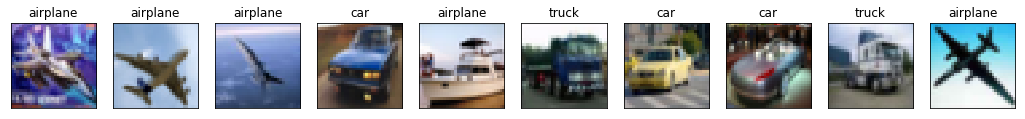

In [91]:
# Plot the results. For instance, you can plot the ten images in subplots with the imshow() function and collect the probabilities in a DataFrame.

# Create figures with subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 10))

# Plot the 10 images
for i, axes in enumerate(axes.flatten()):
    # get the i-th image
    image = rnd_img[i]
    
    # rescale the pixel values between 0 and 1 for plotting, and reshape back to 32x32 pixels and RGB colours (needs and intermedaite step to turn list into column vector with reshape (-1, 1))
    template = MinMaxScaler(feature_range=(0,1)).fit_transform(np.reshape(image, (-1, 1))).reshape(32, 32, 3)
    
    # plot array with imshow()
    axes.imshow(template)
    axes.set_title(most_probable_img['category'][i]) # grab the labels from the most probable category dataframe defined previously
    axes.get_xaxis().set_visible(False) # disable x-axis
    axes.get_yaxis().set_visible(False) # disable y-axis

plt.show()

In [160]:
# Finally, try to vary the regularization strength of your estimator. What is the effect on the probabilities? Write your observations in a markdown cell.
# to avoid running numerous cases, the number of components of the PCA in the best case will be fixed (therefore, 1072), and the regularization strength will be varied between two extremes: two with high mean test accuracy in the cv fitting and two with low mean test accuracy in the cv fitting.

log_fit = [] # create empty list to store the fitting results
alpha = [0.001, 0.1, 1e6, 1e4] # organize the alpha values in a list
img_summary # another empty list

log_grid = ParameterGrid({ # create a grid to iterate through
    'pca__n_components' : [pd.to_numeric(log_df['PCA components'][log_df['mean test accuracy'].idxmax()])],
    'log__alpha' : alpha
})


for i in log_grid:
    # Set parameters
    log_pipe.set_params(**i)
    
    # Fit the logistic classifier
    log_pipe.fit(X_px, y)
    
    # Calculate the probabilities
    i['probabilities'] = pd.DataFrame(log_pipe.predict_proba(rnd_img).round(4))
    
    # Append everything to the initial list
    log_fit.append(i)

In [322]:
# Define a dataframe with the initial alpha values and probabilities from the log_fit
img_summary = log_fit[0]['probabilities'] 
img_summary['alpha'] = log_fit[0]['log__alpha']

for i in np.arange(1,len(log_grid)): # combine them with the rest by appending the dataframe
    df = log_fit[i]['probabilities']
    df['alpha'] = log_fit[i]['log__alpha']
    img_summary = img_summary.append(df)

img_summary = img_summary.reset_index(drop=False) # reset the index and keep the old one as a column, as it corresponds to the number of the randomly selected images

img_summary.columns = ['image number'] + names.tolist() + ['alpha'] # rename the dataframe accordingly
img_summary = img_summary.sort_values(by=['image number']) # sort the dataframe by image number

img_summary = img_summary.melt(id_vars=['image number', 'alpha']) # perform a melt operation to have all the probability and category values grouped by image number and alpha
img_summary.columns = ['image number', 'alpha', 'category', 'probability of the different categories'] # rename the melted dataframe

img_summary = img_summary.set_index(['image number', 'alpha', 'category']).unstack() # create a multilevel index and unstack the last one to get a nice dataframe with the categories as columns and the image number and alpha grouped and indeces
img_summary

probability of the different categories          \
category                                                airplane     car   
image number alpha                                                         
0            0.001                                        1.0000  0.0000   
             0.100                                        0.2904  0.0000   
             10000.000                                    0.2500  0.2500   
             1000000.000                                  0.2520  0.2480   
1            0.001                                        1.0000  0.0000   
             0.100                                        0.9892  0.0000   
             10000.000                                    0.2514  0.2488   
             1000000.000                                  0.2520  0.2480   
2            0.001                                        1.0000  0.0000   
             0.100                                        0.3337  0.0000   
             10000.000                                    0.2504  0.2490   
             1000000.000                                  0.2520  0.2480   
3            0.001                                        0.0000  0.8583   
             0.100                                        0.0001  0.9949   
             10000.000                                    0.2486  0.2515   
             1000000.000                                  0.2520  0.2480   
4            0.001                                        0.3101  0.0000   
             0.100                                        0.7125  0.0002   
             10000.000                                    0.2510  0.2486   
             1000000.000                                  0.2520  0.2480   
5            0.001                                        0.0000  0.0000   
             0.100                                        0.0000  0.0081   
             10000.000                                    0.2487  0.2500   
             1000000.000                                  0.2520  0.2480   
6            0.001                                        0.0000  1.0000   
             0.100                                        0.0002  0.9917   
             10000.000                                    0.2499  0.2508   
             1000000.000                                  0.2520  0.2480   
7            0.001                                        0.0000  1.0000   
             0.100                                        0.0313  0.8764   
             10000.000                                    0.2491  0.2515   
             1000000.000                                  0.2520  0.2480   
8            0.001                                        0.0000  0.0000   
             0.100                                        0.0007  0.0130   
             10000.000                                    0.2496  0.2497   
             1000000.000                                  0.2520  0.2480   
9            0.001                                        1.0000  0.0000   
             0.100                                        0.9998  0.0000   
             10000.000                                    0.2524  0.2488   
             1000000.000                                  0.2520  0.2480   

                                          
category                    ship   truck  
image number alpha                        
0            0.001        0.0000  0.0000  
             0.100        0.7094  0.0002  
             10000.000    0.2502  0.2499  
             1000000.000  0.2520  0.2480  
1            0.001        0.0000  0.0000  
             0.100        0.0099  0.0009  
             10000.000    0.2501  0.2497  
             1000000.000  0.2520  0.2480  
2            0.001        0.0000  0.0000  
             0.100        0.6661  0.0002  
             10000.000    0.2506  0.2500  
             1000000.000  0.2520  0.2480  
3            0.001        0.0000  0.1417  
             0.100        0.0000  0.0050  
             10000.000   

The regularization strength greatly affects the probability distribution of the categories: 

- For small alpha parameters, the algorithm tends to favorize one of the categories, at the most two (one of them with always a really low probability), the remaining being highly unlikely (zero for practical effects). This is by no means a measure of its accuracy, as for example for image zero, where alpha = 0.001 correctly classifies the image while alpha = 0.1 gives more probability to the incorrect category.
- For large alpha parameters, the algorithm tends to have roughly the same probability for every category - and therefore it would be nothing more than random guessing.